# Objective
* 20190907:
    * Given prices for the last N days, we do prediction for the next N+H days, where H is the forecast horizon
    * We use triple exponential smoothing to predict
    * Here we include finetuning on the hyperparameters

In [152]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import multiprocessing
import pandas as pd
import pickle
import time

from collections import defaultdict
from datetime import date, datetime, timedelta
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from pylab import rcParams

#### Input params ##################
stk_path = "./data/VTI_20130102_20181231.csv"
H = 21
train_size = 252*3              # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 63                  # Use 1 year of data as validation set

# alpha - smoothing coeff
alphaMax = 0.999
alphaMin = 0.01
alphaStep = 0.01

# beta - trend coeff
betaMax = 0.999
betaMin = 0.01
betaStep = 0.01

# gamma - seasonality coeff
gammaMax = 0.99
gammaMin = 0.1
gammaStep = 0.1

# finetuning parameters
finetune_width = 0.01       # for alpha and beta
finetune_step = 0.001       # for alpha and beta
finetune_width_gamma = 0.1  # for gamma only
finetune_step_gamma = 0.01  # for gamma only

L = 252                        # seasonality period

# for plot display
daysBackward = 30
daysForward = 60

i_list = range(1008, 1008+84*5+42+1, 42) # we want to do a forecast on these days

fontsize = 14
ticklabelsize = 14
####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 819


In [153]:
inputs = []
alpha = alphaMin
while alpha <= alphaMax:
    beta = betaMin
    while beta <= betaMax:
        gamma = gammaMin
        while gamma <= gammaMax:
            inputs.append((alpha, beta, gamma)) 
            gamma = gamma + gammaStep
        beta = beta + betaStep
    alpha = alpha + alphaStep
print(inputs[-10:])

[(0.9900000000000007, 0.9800000000000006, 0.8999999999999999), (0.9900000000000007, 0.9900000000000007, 0.1), (0.9900000000000007, 0.9900000000000007, 0.2), (0.9900000000000007, 0.9900000000000007, 0.30000000000000004), (0.9900000000000007, 0.9900000000000007, 0.4), (0.9900000000000007, 0.9900000000000007, 0.5), (0.9900000000000007, 0.9900000000000007, 0.6), (0.9900000000000007, 0.9900000000000007, 0.7), (0.9900000000000007, 0.9900000000000007, 0.7999999999999999), (0.9900000000000007, 0.9900000000000007, 0.8999999999999999)]


In [154]:
len(inputs)

88209

In [155]:
print("We will start forecasting on day %d" % (train_val_size+1))

We will start forecasting on day 820


# Common functions

In [156]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

def initial_trend(series, L):
    """
    Initial trend, b_1 = ( (y_L+1 - y_1)/L + (y_L+2 - y_2)/L + ... + (y_L+L - y_L)/L ) / L
    """
    sum = 0.0
    for i in range(L):
        sum += float(series[i+L] - series[i]) / L
        
    return sum / L

def initial_seasonal_components(series, L):
    """
    Initial seasonal index, 
    I_t = ( y_t-A_1 + y_{t+L}-A_2 + ... + y_{t+(P-1)L}-A_P ) / P, 
    t = 1, 2, ..., L
    Here P is the number of seasons we have in the series.
    For example, for sales data, we have 2018 Q1, 2018 Q2, 2018 Q3, 2018 Q4 data. These 4 points represent 1 season.
    A_1 is the mean of the values in the first season, and so on.
    Returns the seasonal components of length L in a list
    """
    seasonals = []
    season_averages = []
    n_seasons = int(len(series)/L)
    
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[L*j:L*j+L])/float(L))
    
    # compute initial values
    for i in range(L):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[L*j+i]-season_averages[j]
        seasonals.append(sum_of_vals_over_avg/n_seasons)
        
    return seasonals

def triple_exponential_smoothing(series, L, H, alpha=0.3, beta=0.3, gamma=0.3, return_all=False):
    """
    Overall smoothing:  S_t = alpha*(y_t - I_{t-L}) + (1-alpha)(S_{t-1} + b_{t-1}})
    Trend smoothing:    b_t = beta*(S_t - S_{t-1}) + (1-beta)*b_{t-1}
    Seasonal smoothing: I_t = gamma*(y_t - S_t) + (1-gamma)*I_{t-L}
    Forecast:           F_{t+m} = S_t + m*b_t + I_{t-L+m}, m >= 1
    Note here m has to be < len(series)
    result[len(series)] is the estimate of series[len(series)]
    The length of result is len(series) + H, where H >= 1
    """
    result = [0, series[0]]
    smooth = series[0]
    trend = initial_trend(series, L)
    seasonals = initial_seasonal_components(series, L)
    seasonals.append(seasonals[0]) # To make the seasonals elements align with series elements
    for n in range(1, len(series)+H-1):
        if n >= len(series): # we are forecasting
            m = n - len(series) + 2
            result.append(smooth + m*trend + seasonals[n+1])
        else:
            val = series[n]
            last_smooth, smooth = smooth, alpha*(val-seasonals[n]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals.append(gamma*(val-smooth) + (1-gamma)*seasonals[n])
            result.append(smooth + trend + seasonals[n+1])
            # e.g. result[2] uses series[1], seasonals[1], and seasonals[2]
            # ie. result[2] is the estimate of series[2]
            # e.g. result[len(series)] uses series[len(series)-1], seasonals[len(series)-1], and seasonals[len(series)] 
            # ie. result[len(series)] is the estimate of series[len(series)]
            
    if return_all == True:
        return result, seasonals
    else:
        return result[len(series):len(series)+H], seasonals

def get_error_metrics(series, train_size, L, H, alpha, beta, gamma):
    """
    Given a series consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        series     : series to forecast, with length = (train_size + val_size)
        train_size : length of series to use as train ie. train set is series[:train_size]
        L          : period
        H          : forecast horizon
        alpha      : smoothing coeff
        beta       : trend coeff
        gamma      : seasonality coeff
    Outputs
        mean of rmse, mean of mape, mean of mae
    """
    # Predict using single exponential smoothing, and compute error metrics also
    rmse = [] # root mean square error
    mape = [] # mean absolute percentage error
    mae = []  # mean absolute error
    preds_dict = {}
    
    for i in range(train_size, len(series)-H+1, int(H/2)):
        preds_list, seasonals = triple_exponential_smoothing(series[i-train_size:i], L, H, alpha, beta, gamma)
        
        rmse.append(get_rmse(series[i:i+H], preds_list))
        mape.append(get_mape(series[i:i+H], preds_list))
        mae.append(get_mae(series[i:i+H], preds_list))
        preds_dict[i] = preds_list
    
    return np.mean(rmse), np.mean(mape), np.mean(mae), preds_dict    

In [157]:
def hyperparam_tune_alpha_beta_gamma_finetune(series, train_size, L, H, finetune_width, finetune_step):
    """
    Given a series, tune hyperparameter alpha, fit and predict
    Inputs
        series     : series to forecast, with length = (train_size + val_size)
        train_size : length of series to use as train ie. train set is series[:train_size]
        L          : period
        H          : forecast horizon
        finetune_width : do finetuning at +/- finetune_width
        finetune_step  : do finetuning at increments of finetune_step
    Outputs
        optimum hyperparameters, error metrics dataframe
    """
    err_dict = defaultdict(list)
    alpha = alphaMin
    while alpha <= alphaMax:
        beta = betaMin
        while beta <= betaMax:
            gamma = gammaMin
            while gamma <= gammaMax:
                rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(series, train_size, L, H, alpha, beta, gamma)
        
                # Append alpha and beta
                err_dict['alpha'].append(alpha)
                err_dict['beta'].append(beta)
                err_dict['gamma'].append(gamma)
    
                # Compute error metrics
                err_dict['rmse'].append(rmse_mean)
                err_dict['mape'].append(mape_mean)
                err_dict['mae'].append(mae_mean)
                
                # Increase gamma by one step
                gamma = gamma + gammaStep
            
            # Increase beta by one step
            beta = beta + betaStep
        
        # Increase alpha by one step
        alpha = alpha + alphaStep
    
    # Convert to dataframe
    err_df = pd.DataFrame(err_dict)
    
    # Get min RMSE
    rmse_min = err_df['rmse'].min()
    
    alpha_opt = err_df[err_df['rmse'] == rmse_min]['alpha'].values[0]
    beta_opt = err_df[err_df['rmse'] == rmse_min]['beta'].values[0]
    gamma_opt = err_df[err_df['rmse'] == rmse_min]['gamma'].values[0]
    print("alpha_opt = " + str(alpha_opt) + 
          ", beta_opt = " + str(beta_opt) + 
          ", gamma_opt = " + str(gamma_opt) + 
          ", rmse_min = " + str(rmse_min))
    
    # finetune
    err_dict_finetune = defaultdict(list)
    alpha = max(0, alpha_opt - finetune_width)
    while alpha <= min(1, alpha_opt + finetune_width):
        beta = max(0, beta_opt - finetune_width)
        while beta <= min(1, beta_opt + finetune_width):
            gamma = max(0, gamma_opt - finetune_width)
            while gamma <= min(1, gamma_opt + finetune_width):
                rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(series, train_size, L, H, alpha, beta, gamma)
        
                # Append alpha and beta
                err_dict_finetune['alpha'].append(alpha)
                err_dict_finetune['beta'].append(beta)
                err_dict_finetune['gamma'].append(gamma)
    
                # Compute error metrics
                err_dict_finetune['rmse'].append(rmse_mean)
                err_dict_finetune['mape'].append(mape_mean)
                err_dict_finetune['mae'].append(mae_mean)
                
                # Increase gamma by one step
                gamma = gamma + finetune_step
            
            # Increase beta by one step
            beta = beta + finetune_step
        
        # Increase alpha by one step
        alpha = alpha + finetune_step
        
    # Convert to dataframe
    err_df_finetune = pd.DataFrame(err_dict_finetune)
    
    # Get min RMSE
    rmse_min = err_df_finetune['rmse'].min()
    
    alpha_opt_finetune = err_df_finetune[err_df_finetune['rmse'] == rmse_min]['alpha'].values[0]
    beta_opt_finetune = err_df_finetune[err_df_finetune['rmse'] == rmse_min]['beta'].values[0]
    gamma_opt_finetune = err_df_finetune[err_df_finetune['rmse'] == rmse_min]['gamma'].values[0]
    print("alpha_opt_finetune = " + str(alpha_opt_finetune) + 
          ", beta_opt_finetune = " + str(beta_opt_finetune) + 
          ", gamma_opt_finetune = " + str(gamma_opt_finetune) + 
          ", rmse_min_finetune = " + str(rmse_min))
    
    return alpha_opt_finetune, beta_opt_finetune, gamma_opt_finetune, err_df_finetune

In [158]:
def processInput(i, series, train_size, L, H, alpha, beta, gamma):
    preds_list, seasonals = triple_exponential_smoothing(series[i-train_size:i], L, H, alpha, beta, gamma)
        
    rmse = get_rmse(series[i:i+H], preds_list)
    mape = get_mape(series[i:i+H], preds_list)
    mae = get_mae(series[i:i+H], preds_list)

    return (rmse, mape, mae, preds_list, i)

def get_error_metrics_parallelized(series, train_size, L, H, alpha, beta, gamma):
    """
    This is a parallelized implementation of get_error_metrics.
    Given a series consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        series     : series to forecast, with length = (train_size + val_size)
        train_size : length of series to use as train ie. train set is series[:train_size]
        L          : period
        H          : forecast horizon
        alpha      : smoothing coeff
        beta       : trend coeff
        gamma      : seasonality coeff
    Outputs
        mean of rmse, mean of mape, mean of mae
    """
    inputs = range(train_size, len(series)-H+1, int(H/2))

    num_cores = multiprocessing.cpu_count()

    results = Parallel(n_jobs=num_cores)(delayed(processInput)(i, series, train_size, L, H, alpha, beta, gamma) for i in inputs)
    # results has format [(rmse1, mape1, mae1, preds_list1, i1), (rmse2, mape2, mae2, preds_list2, i2), ...]
    
    rmse = [] # root mean square error
    mape = [] # mean absolute percentage error
    mae = []  # mean absolute error
    preds_dict = {}
    for item in results:
        rmse.append(item[0])
        mape.append(item[1])
        mae.append(item[2])
        preds_dict[item[4]] = item[3]
        
    return np.mean(rmse), np.mean(mape), np.mean(mae), preds_dict
    
def hyperparam_tune_alpha_beta_gamma_finetune_parallelized(series, train_size, L, H, finetune_width, finetune_step):
    """
    This is a parallelized implementation of hyperparam_tune_alpha_beta_gamma_finetune.
    Given a series, tune hyperparameter alpha, fit and predict
    Inputs
        series     : series to forecast, with length = (train_size + val_size)
        train_size : length of series to use as train ie. train set is series[:train_size]
        L          : period
        H          : forecast horizon
        finetune_width : do finetuning at +/- finetune_width
        finetune_step  : do finetuning at increments of finetune_step
    Outputs
        optimum hyperparameters, error metrics dataframe
    """
    err_dict = defaultdict(list)
    alpha = alphaMin
    while alpha <= alphaMax:
        beta = betaMin
        while beta <= betaMax:
            gamma = gammaMin
            while gamma <= gammaMax:
                rmse_mean, mape_mean, mae_mean, _ = get_error_metrics_parallelized(series, train_size, L, H, alpha, beta, gamma)
        
                # Append alpha and beta
                err_dict['alpha'].append(alpha)
                err_dict['beta'].append(beta)
                err_dict['gamma'].append(gamma)
    
                # Compute error metrics
                err_dict['rmse'].append(rmse_mean)
                err_dict['mape'].append(mape_mean)
                err_dict['mae'].append(mae_mean)
                
                # Increase gamma by one step
                gamma = gamma + gammaStep
            
            # Increase beta by one step
            beta = beta + betaStep
        
        # Increase alpha by one step
        alpha = alpha + alphaStep
    
    # Convert to dataframe
    err_df = pd.DataFrame(err_dict)
    
    # Get min RMSE
    rmse_min = err_df['rmse'].min()
    
    alpha_opt = err_df[err_df['rmse'] == rmse_min]['alpha'].values[0]
    beta_opt = err_df[err_df['rmse'] == rmse_min]['beta'].values[0]
    gamma_opt = err_df[err_df['rmse'] == rmse_min]['gamma'].values[0]
    print("alpha_opt = " + str(alpha_opt) + 
          ", beta_opt = " + str(beta_opt) + 
          ", gamma_opt = " + str(gamma_opt) + 
          ", rmse_min = " + str(rmse_min))
    
    # finetune
    err_dict_finetune = defaultdict(list)
    alpha = max(0, alpha_opt - finetune_width)
    while alpha <= min(1, alpha_opt + finetune_width):
        beta = max(0, beta_opt - finetune_width)
        while beta <= min(1, beta_opt + finetune_width):
            gamma = max(0, gamma_opt - finetune_width)
            while gamma <= min(1, gamma_opt + finetune_width):
                rmse_mean, mape_mean, mae_mean, _ = get_error_metrics_parallelized(series, train_size, L, H, alpha, beta, gamma)
        
                # Append alpha and beta
                err_dict_finetune['alpha'].append(alpha)
                err_dict_finetune['beta'].append(beta)
                err_dict_finetune['gamma'].append(gamma)
    
                # Compute error metrics
                err_dict_finetune['rmse'].append(rmse_mean)
                err_dict_finetune['mape'].append(mape_mean)
                err_dict_finetune['mae'].append(mae_mean)
                
                # Increase gamma by one step
                gamma = gamma + finetune_step
            
            # Increase beta by one step
            beta = beta + finetune_step
        
        # Increase alpha by one step
        alpha = alpha + finetune_step
        
    # Convert to dataframe
    err_df_finetune = pd.DataFrame(err_dict_finetune)
    
    # Get min RMSE
    rmse_min = err_df_finetune['rmse'].min()
    
    alpha_opt_finetune = err_df_finetune[err_df_finetune['rmse'] == rmse_min]['alpha'].values[0]
    beta_opt_finetune = err_df_finetune[err_df_finetune['rmse'] == rmse_min]['beta'].values[0]
    gamma_opt_finetune = err_df_finetune[err_df_finetune['rmse'] == rmse_min]['gamma'].values[0]
    print("alpha_opt_finetune = " + str(alpha_opt_finetune) + 
          ", beta_opt_finetune = " + str(beta_opt_finetune) + 
          ", gamma_opt_finetune = " + str(gamma_opt_finetune) + 
          ", rmse_min_finetune = " + str(rmse_min))
    
    return alpha_opt_finetune, beta_opt_finetune, gamma_opt_finetune, err_df_finetune

In [159]:
def get_error_metrics2(series, train_size, L, H, alpha, beta, gamma):
    """
    Given a series consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        series     : series to forecast, with length = (train_size + val_size)
        train_size : length of series to use as train ie. train set is series[:train_size]
        L          : period
        H          : forecast horizon
        alpha      : smoothing coeff
        beta       : trend coeff
        gamma      : seasonality coeff
    Outputs
        mean of rmse, mean of mape, mean of mae
    """
    # Predict using single exponential smoothing, and compute error metrics also
    rmse = [] # root mean square error
    mape = [] # mean absolute percentage error
    mae = []  # mean absolute error
    preds_dict = {}
    
    for i in range(train_size, len(series)-H+1, int(H/2)):
        preds_list, seasonals = triple_exponential_smoothing(series[i-train_size:i], L, H, alpha, beta, gamma)
        
        rmse.append(get_rmse(series[i:i+H], preds_list))
        mape.append(get_mape(series[i:i+H], preds_list))
        mae.append(get_mae(series[i:i+H], preds_list))
        preds_dict[i] = preds_list
    
    return np.mean(rmse), np.mean(mape), np.mean(mae), preds_dict, alpha, beta, gamma   

def hyperparam_tune_alpha_beta_gamma_finetune_parallelized2(series, 
                                                            train_size, 
                                                            L, 
                                                            H, 
                                                            finetune_width, 
                                                            finetune_step, 
                                                            finetune_width_gamma, 
                                                            finetune_step_gamma):
    """
    This is a parallelized implementation of hyperparam_tune_alpha_beta_gamma_finetune.
    Given a series, tune hyperparameter alpha, fit and predict
    Inputs
        series     : series to forecast, with length = (train_size + val_size)
        train_size : length of series to use as train ie. train set is series[:train_size]
        L          : period
        H          : forecast horizon
        finetune_width : do finetuning at +/- finetune_width
        finetune_step  : do finetuning at increments of finetune_step
        finetune_width_gamma : do finetuning at +/- finetune_width. This is for gamma only
        finetune_step_gamma  : do finetuning at increments of finetune_step. This is for gamma only
    Outputs
        optimum hyperparameters, error metrics dataframe
    """
    num_cores = multiprocessing.cpu_count()
    inputs = []
    alpha = alphaMin
    while alpha <= alphaMax:
        beta = betaMin
        while beta <= betaMax:
            gamma = gammaMin
            while gamma <= gammaMax:
                inputs.append((alpha, beta, gamma)) 
                gamma = gamma + gammaStep
            beta = beta + betaStep
        alpha = alpha + alphaStep
        
    results = Parallel(n_jobs=num_cores)(delayed(get_error_metrics2)(series, train_size, L, H, item[0], item[1], item[2]) for item in inputs)
    # results has format [(rmse_mean1, mape_mean1, mae_mean1, preds_dict1, alpha1, beta1, gamma1), (rmse_mean2, mape_mean2, mae_mean2, preds_dict2, alpha2, beta2, gamma2), ...]   
    
    err_dict = defaultdict(list)
    for item in results:
        # Append error metrics
        err_dict['rmse'].append(item[0])
        err_dict['mape'].append(item[1])
        err_dict['mae'].append(item[2])
        
        # Append alpha and beta
        err_dict['alpha'].append(item[4])
        err_dict['beta'].append(item[5])
        err_dict['gamma'].append(item[6])
         
    # Convert to dataframe
    err_df = pd.DataFrame(err_dict)
    
    # Get min RMSE
    rmse_min = err_df['rmse'].min()
    
    alpha_opt = err_df[err_df['rmse'] == rmse_min]['alpha'].values[0]
    beta_opt = err_df[err_df['rmse'] == rmse_min]['beta'].values[0]
    gamma_opt = err_df[err_df['rmse'] == rmse_min]['gamma'].values[0]
    print("alpha_opt = " + str(alpha_opt) + 
          ", beta_opt = " + str(beta_opt) + 
          ", gamma_opt = " + str(gamma_opt) + 
          ", rmse_min = " + str(rmse_min))
    
    # finetune
    inputs = []
    alpha = max(0, alpha_opt - finetune_width)
    while alpha <= min(1, alpha_opt + finetune_width):
        beta = max(0, beta_opt - finetune_width)
        while beta <= min(1, beta_opt + finetune_width):
            gamma = max(0, gamma_opt - finetune_width_gamma)
            while gamma <= min(1, gamma_opt + finetune_width_gamma):
                inputs.append((alpha, beta, gamma)) 
                gamma = gamma + finetune_step_gamma
            beta = beta + finetune_step
        alpha = alpha + finetune_step
        
    results = Parallel(n_jobs=num_cores)(delayed(get_error_metrics2)(series, train_size, L, H, item[0], item[1], item[2]) for item in inputs)
    # results has format [(rmse_mean1, mape_mean1, mae_mean1, preds_dict1, alpha1, beta1, gamma1), (rmse_mean2, mape_mean2, mae_mean2, preds_dict2, alpha2, beta2, gamma2), ...]   
    
    err_dict_finetune = defaultdict(list)
    for item in results:
        # Append error metrics
        err_dict_finetune['rmse'].append(item[0])
        err_dict_finetune['mape'].append(item[1])
        err_dict_finetune['mae'].append(item[2])
        
        # Append alpha and beta
        err_dict_finetune['alpha'].append(item[4])
        err_dict_finetune['beta'].append(item[5])
        err_dict_finetune['gamma'].append(item[6])
    
    # Convert to dataframe
    err_df_finetune = pd.DataFrame(err_dict_finetune)
    
    # Get min RMSE
    rmse_min = err_df_finetune['rmse'].min()
    
    alpha_opt_finetune = err_df_finetune[err_df_finetune['rmse'] == rmse_min]['alpha'].values[0]
    beta_opt_finetune = err_df_finetune[err_df_finetune['rmse'] == rmse_min]['beta'].values[0]
    gamma_opt_finetune = err_df_finetune[err_df_finetune['rmse'] == rmse_min]['gamma'].values[0]
    print("alpha_opt_finetune = " + str(alpha_opt_finetune) + 
          ", beta_opt_finetune = " + str(beta_opt_finetune) + 
          ", gamma_opt_finetune = " + str(gamma_opt_finetune) + 
          ", rmse_min_finetune = " + str(rmse_min))
    
    return alpha_opt_finetune, beta_opt_finetune, gamma_opt_finetune, err_df_finetune

# Load data

In [160]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume
0,2013-01-02,74.529999,75.150002,74.500000,75.139999,66.997757,5037200
1,2013-01-03,75.120003,75.370003,74.839996,75.029999,66.899689,2634600
2,2013-01-04,75.139999,75.519997,74.989998,75.410004,67.238510,2512900
3,2013-01-07,75.180000,75.279999,74.949997,75.209999,67.060173,2511200
4,2013-01-08,75.110001,75.180000,74.699997,75.010002,66.881859,1407900
5,2013-01-09,75.190002,75.410004,75.110001,75.239998,67.086937,1421900
6,2013-01-10,75.620003,75.769997,75.220001,75.760002,67.550591,1403700
7,2013-01-11,75.760002,75.800003,75.510002,75.769997,67.559486,1248500
8,2013-01-14,75.750000,75.800003,75.440002,75.690002,67.488159,2745100
9,2013-01-15,75.400002,75.889999,75.339996,75.830002,67.612984,1109100


In [161]:
df['date'].min(), df['date'].max() 

(Timestamp('2013-01-02 00:00:00'), Timestamp('2018-12-28 00:00:00'))

Text(0, 0.5, 'USD')

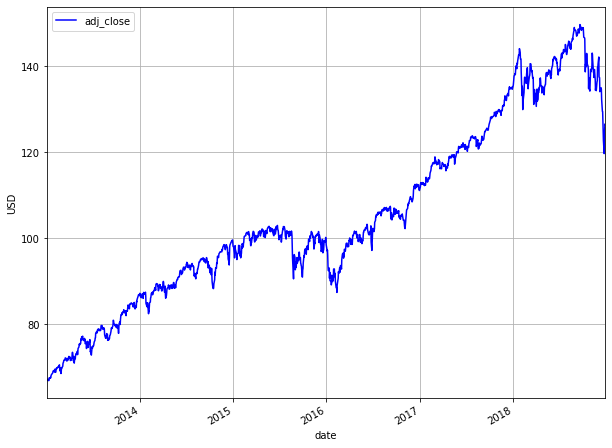

In [162]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Predict for a specific H (forecast horizon) and a specific date, plot original series too

In [163]:
i = 1008 # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df.iloc[i]['date'], H))

Predicting on day 1008, date 2017-01-03 00:00:00, with forecast horizon H = 21


In [164]:
# Predict
preds_list, seasonals = triple_exponential_smoothing(df['adj_close'][i-train_val_size:i].values, L, H, 0.3, 0.55, 0.6, True)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['adj_close'], preds_list[train_val_size:train_val_size+H])))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['adj_close'], preds_list[train_val_size:train_val_size+H])))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['adj_close'], preds_list[train_val_size:train_val_size+H])))

For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 8.016099
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 6.792686
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 7.677130


(735144.0, 736353.0)

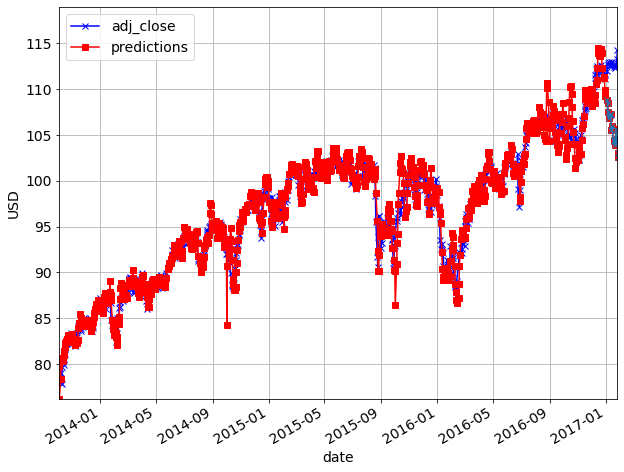

In [165]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i-train_val_size:i+H], preds_list, marker='s', color='r')
ax.plot(df['date'][i:i+H], preds_list[train_val_size:train_val_size+H], marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([min(min(preds_list[1:]), df[(df['date']>=df['date'][i]-timedelta(days=daysBackward)) & (df['date']<=df['date'][i]+timedelta(days=daysForward))]['adj_close'].min()), 
             max(max(preds_list[1:]), df[(df['date']>=df['date'][i]-timedelta(days=daysBackward)) & (df['date']<=df['date'][i]+timedelta(days=daysForward))]['adj_close'].max())])
ax.set_xlim([df['date'][i-train_val_size+1], df['date'][i]+timedelta(days=H)])
# ax.set_xlim(['2016-06-01', '2017-02-01'])
# ax.set_ylim([60, 85])

Text(0, 0.5, 'Seasonal components')

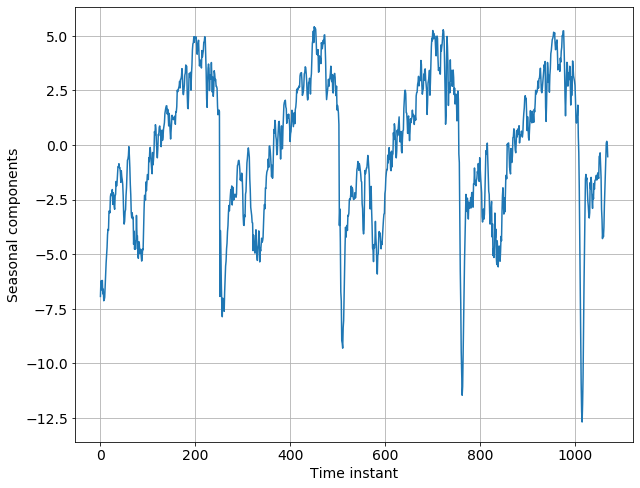

In [166]:
# Plot the seasonals
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

plt.plot(seasonals)
plt.grid()
plt.xlabel("Time instant")
plt.ylabel("Seasonal components")
# plt.xlim([0, 252])

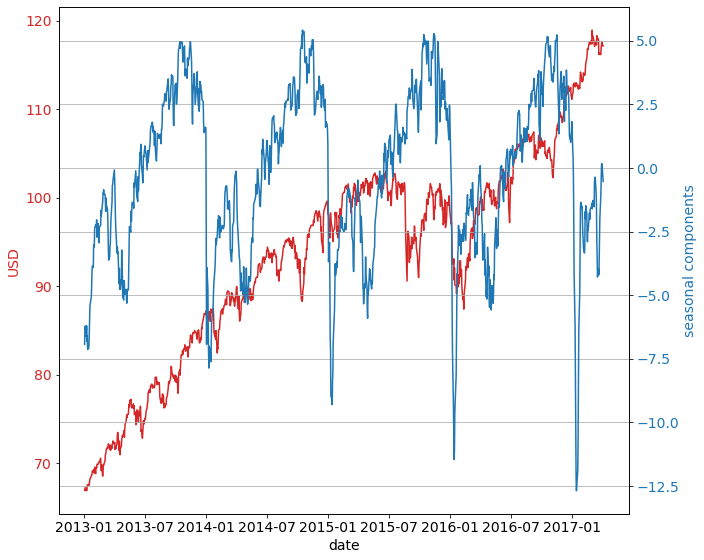

In [167]:
# Plot the seasonals with actual values on dual axes
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('USD', color=color)
ax1.plot(df['date'][:len(seasonals)], df['adj_close'][:len(seasonals)], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('seasonal components', color=color)  # we already handled the x-label with ax1
ax2.plot(df['date'][:len(seasonals)], seasonals, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# ax1.set_xlim(['2016-01-01', '2016-12-31'])
plt.grid()
plt.show()

# Predict for a specific H (forecast horizon) and a specific date

In [168]:
i = 1008 # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df.iloc[i]['date'], H))

Predicting on day 1008, date 2017-01-03 00:00:00, with forecast horizon H = 21


In [169]:
# Predict
preds_list, seasonals = triple_exponential_smoothing(df['adj_close'][i-train_val_size:i].values, L, H, 0.3, 0.55, 0.6)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['adj_close'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['adj_close'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['adj_close'], preds_list)))

For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 8.016099
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 6.792686
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 7.677130


(736302.0, 736392.0)

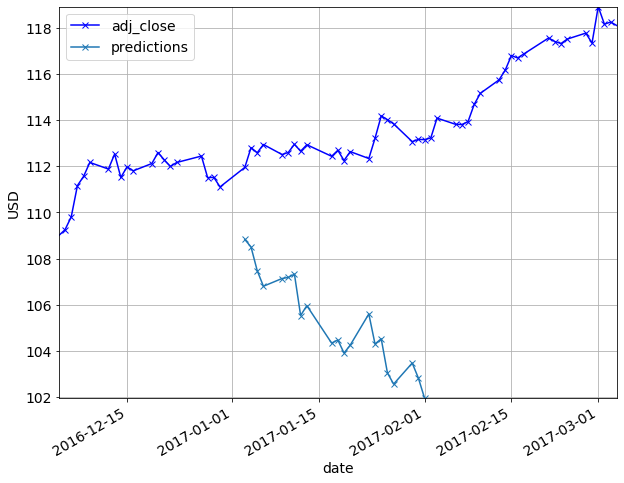

In [170]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([min(min(preds_list), df[(df['date']>=df['date'][i]-timedelta(days=daysBackward)) & (df['date']<=df['date'][i]+timedelta(days=daysForward))]['adj_close'].min()), 
             max(max(preds_list), df[(df['date']>=df['date'][i]-timedelta(days=daysBackward)) & (df['date']<=df['date'][i]+timedelta(days=daysForward))]['adj_close'].max())])
ax.set_xlim([df['date'][i]-timedelta(days=daysBackward), df['date'][i]+timedelta(days=daysForward)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - alpha, beta, gamma

In [171]:
i = 1008 # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df.iloc[i]['date'], H))

Predicting on day 1008, date 2017-01-03 00:00:00, with forecast horizon H = 21


In [172]:
# # Get optimum hyperparams
# tic = time.time()
# alpha_opt, beta_opt, gamma_opt, err_df = \
#     hyperparam_tune_alpha_beta_gamma_finetune(df['adj_close'][i-train_val_size:i].values, train_size, L, H, finetune_width, finetune_step)
# toc = time.time()
# print("Time taken = {0:.2f} mins".format((toc-tic)/60.0))

# print("alpha_opt = " + str(alpha_opt))
# print("beta_opt = " + str(beta_opt))
# print("gamma_opt = " + str(gamma_opt))
# print("rmse opt = " + str(err_df[(err_df['alpha']==alpha_opt) & (err_df['beta']==beta_opt)]['rmse'].values[0]))
# err_df

In [173]:
# # Get optimum hyperparams - parallelized
# tic = time.time()
# alpha_opt, beta_opt, gamma_opt, err_df = \
#     hyperparam_tune_alpha_beta_gamma_finetune_parallelized(df['adj_close'][i-train_val_size:i].values, train_size, L, H, finetune_width, finetune_step)
# toc = time.time()
# print("Time taken = {0:.2f} mins".format((toc-tic)/60.0))

# print("alpha_opt = " + str(alpha_opt))
# print("beta_opt = " + str(beta_opt))
# print("gamma_opt = " + str(gamma_opt))
# print("rmse opt = " + str(err_df[(err_df['alpha']==alpha_opt) & (err_df['beta']==beta_opt)]['rmse'].values[0]))
# err_df

In [174]:
# Get optimum hyperparams - parallelized2
tic = time.time()
alpha_opt, beta_opt, gamma_opt, err_df = \
    hyperparam_tune_alpha_beta_gamma_finetune_parallelized2(df['adj_close'][i-train_val_size:i].values, 
                                                            train_size, 
                                                            L, 
                                                            H, 
                                                            finetune_width, 
                                                            finetune_step, 
                                                            finetune_width_gamma, 
                                                            finetune_step_gamma)
toc = time.time()
print("Time taken = {0:.2f} mins".format((toc-tic)/60.0))

print("alpha_opt = " + str(alpha_opt))
print("beta_opt = " + str(beta_opt))
print("gamma_opt = " + str(gamma_opt))
print("rmse opt = " + str(err_df[(err_df['alpha']==alpha_opt) & (err_df['beta']==beta_opt)]['rmse'].values[0]))
err_df

alpha_opt = 0.03, beta_opt = 0.2700000000000001, gamma_opt = 0.6, rmse_min = 1.8220924442824113
alpha_opt_finetune = 0.029000000000000005, beta_opt_finetune = 0.2800000000000001, gamma_opt_finetune = 0.5700000000000001, rmse_min_finetune = 1.6659237555929067
Time taken = 9.26 mins
alpha_opt = 0.029000000000000005
beta_opt = 0.2800000000000001
gamma_opt = 0.5700000000000001
rmse opt = 2.3870121259316277


,rmse,mape,mae,alpha,beta,gamma
0,11.242954,9.395178,10.084468,0.020,0.26,0.50
1,11.301803,9.443740,10.135662,0.020,0.26,0.51
2,11.370901,9.495887,10.190824,0.020,0.26,0.52
3,11.451008,9.552487,10.250731,0.020,0.26,0.53
4,11.542602,9.621633,10.324148,0.020,0.26,0.54
...,...,...,...,...,...,...
8395,9.305073,7.713215,8.277426,0.039,0.28,0.65
8396,9.453706,7.879555,8.453904,0.039,0.28,0.66
8397,9.614331,8.050479,8.635289,0.039,0.28,0.67
8398,9.787768,8.242790,8.839873,0.039,0.28,0.68


In [175]:
# Predict
preds_list, seasonals = triple_exponential_smoothing(df['adj_close'][i-train_val_size:i].values, L, H, alpha_opt, beta_opt, gamma_opt)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['adj_close'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['adj_close'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['adj_close'], preds_list)))

For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 2.703389
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 1.906409
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 2.147813


(736302.0, 736392.0)

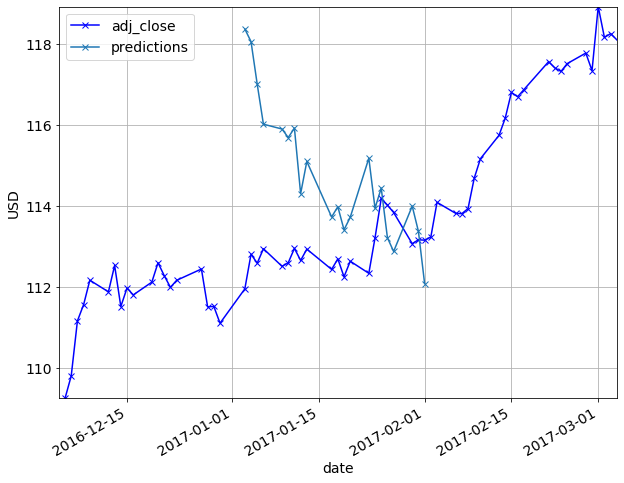

In [176]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([min(min(preds_list), df[(df['date']>=df['date'][i]-timedelta(days=daysBackward)) & (df['date']<=df['date'][i]+timedelta(days=daysForward))]['adj_close'].min()), 
             max(max(preds_list), df[(df['date']>=df['date'][i]-timedelta(days=daysBackward)) & (df['date']<=df['date'][i]+timedelta(days=daysForward))]['adj_close'].max())])
ax.set_xlim([df['date'][i]-timedelta(days=daysBackward), df['date'][i]+timedelta(days=daysForward)])

# Predict for a specific H (forecast horizon), and various dates, using model trained in previous step

In [177]:
print("alpha_opt = " + str(alpha_opt))
print("beta_opt = " + str(beta_opt))
print("gamma_opt = " + str(gamma_opt))

alpha_opt = 0.029000000000000005
beta_opt = 0.2800000000000001
gamma_opt = 0.5700000000000001


In [178]:
# Predict and compute error metrics also
preds_dict = {}
results_final_no_tune = defaultdict(list)
for i in i_list:
    print("Predicting on day %d, date %s" % (i, df.iloc[i]['date']))
        
    preds_list, seasonals = triple_exponential_smoothing(df['adj_close'][i-train_val_size:i].values, L, H, alpha_opt, beta_opt, gamma_opt)
    
    # Collect the predictions
    preds_dict[i] = preds_list
    
    # Compute error metrics
    results_final_no_tune['rmse'].append(get_rmse(df[i:i+H]['adj_close'], preds_list))
    results_final_no_tune['mape'].append(get_mape(df[i:i+H]['adj_close'], preds_list))
    results_final_no_tune['mae'].append(get_mae(df[i:i+H]['adj_close'], preds_list))
    results_final_no_tune['day'].append(df.iloc[i]['date'])
    
results_final_no_tune = pd.DataFrame(results_final_no_tune)

print("Altogether we made %d forecasts, each of length %d days" % (len(results_final_no_tune), H))

Predicting on day 1008, date 2017-01-03 00:00:00
Predicting on day 1050, date 2017-03-06 00:00:00
Predicting on day 1092, date 2017-05-04 00:00:00
Predicting on day 1134, date 2017-07-05 00:00:00
Predicting on day 1176, date 2017-09-01 00:00:00
Predicting on day 1218, date 2017-11-01 00:00:00
Predicting on day 1260, date 2018-01-03 00:00:00
Predicting on day 1302, date 2018-03-06 00:00:00
Predicting on day 1344, date 2018-05-04 00:00:00
Predicting on day 1386, date 2018-07-05 00:00:00
Predicting on day 1428, date 2018-09-04 00:00:00
Predicting on day 1470, date 2018-11-01 00:00:00
Altogether we made 12 forecasts, each of length 21 days


In [179]:
print("For forecast horizon %d, the mean RMSE is %f" % (H, results_final_no_tune['rmse'].mean()))
print("For forecast horizon %d, the mean MAPE is %f" % (H, results_final_no_tune['mape'].mean()))
print("For forecast horizon %d, the mean MAE is %f" % (H, results_final_no_tune['mae'].mean()))

# Put results into pickle
pickle.dump(results_final_no_tune['rmse'].mean(), 
            open("./out/rmse_no_tune_v5a_" + str(train_size) + "_" + str(val_size) + ".pickle", "wb"))

For forecast horizon 21, the mean RMSE is 10.158113
For forecast horizon 21, the mean MAPE is 7.157940
For forecast horizon 21, the mean MAE is 9.469042


In [180]:
results_final_no_tune['alpha_opt'] = [alpha_opt]*len(i_list)
results_final_no_tune['beta_opt'] = [beta_opt]*len(i_list)
results_final_no_tune['gamma_opt'] = [gamma_opt]*len(i_list)
results_final_no_tune

,rmse,mape,mae,day,alpha_opt,beta_opt,gamma_opt
0,2.703389,1.906409,2.147813,2017-01-03,0.029,0.28,0.57
1,10.508508,8.909311,10.443009,2017-03-06,0.029,0.28,0.57
2,13.059420,10.226375,12.216257,2017-05-04,0.029,0.28,0.57
3,4.594209,3.335723,4.080802,2017-07-05,0.029,0.28,0.57
4,5.032876,3.762933,4.682825,2017-09-01,0.029,0.28,0.57
5,11.774071,8.931849,11.626835,2017-11-01,0.029,0.28,0.57
6,6.674460,4.430621,6.245849,2018-01-03,0.029,0.28,0.57
7,16.317781,10.381351,13.966482,2018-03-06,0.029,0.28,0.57
8,24.690028,17.746694,24.514088,2018-05-04,0.029,0.28,0.57
9,3.542159,1.786706,2.564894,2018-07-05,0.029,0.28,0.57


(736302.0, 737059.0)

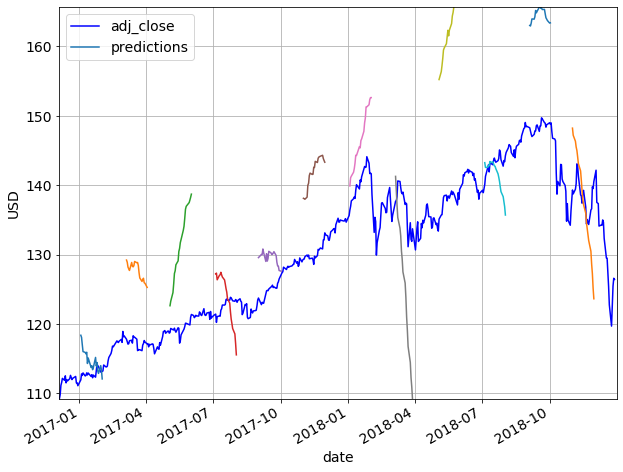

In [181]:
# Plot the predictions, and zoom in
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
firstDay = df['date'][min(i_list)]-timedelta(days=daysBackward)
lastDay = df['date'][max(i_list)]+timedelta(days=daysForward)
ax.set_ylim([min(min(min(preds_dict.values())), 
                 df[(df['date']>=firstDay) & (df['date']<=lastDay)]['adj_close'].min()
                ), 
             max(max(max(preds_dict.values())), 
                 df[(df['date']>=firstDay) & (df['date']<=lastDay)]['adj_close'].max()
                )
            ])
ax.set_xlim([firstDay, lastDay]) 

# Predict for a specific H (forecast horizon), and various dates, tuning model for every prediction

In [182]:
# Predict and compute error metrics also
preds_dict = {}
results_final = defaultdict(list)
tic = time.time()
for i in i_list:
    print(time.asctime( time.localtime(time.time()) ))
    tic1 = time.time()
    print("Predicting on day %d, date %s" % (i, df.iloc[i]['date']))
    
    # Get optimum hyperparams
    alpha_opt, beta_opt, gamma_opt, err_df = \
        hyperparam_tune_alpha_beta_gamma_finetune_parallelized2(df['adj_close'][i-train_val_size:i].values, 
                                                                train_size, 
                                                                L, 
                                                                H, 
                                                                finetune_width, 
                                                                finetune_step,
                                                                finetune_width_gamma, 
                                                                finetune_step_gamma)
        
    preds_list, seasonals = triple_exponential_smoothing(df['adj_close'][i-train_val_size:i].values, L, H, alpha_opt, beta_opt, gamma_opt)
    
    # Collect the predictions
    preds_dict[i] = preds_list
    
    # Compute error metrics
    results_final['rmse'].append(get_rmse(df[i:i+H]['adj_close'], preds_list))
    results_final['mape'].append(get_mape(df[i:i+H]['adj_close'], preds_list))
    results_final['mae'].append(get_mae(df[i:i+H]['adj_close'], preds_list))
    results_final['alpha_opt'].append(alpha_opt)
    results_final['beta_opt'].append(beta_opt)
    results_final['gamma_opt'].append(gamma_opt)
    results_final['day'].append(df.iloc[i]['date'])
    
    toc1 = time.time()
    print("Time taken = {0:.2f} mins".format((toc1-tic1)/60.0))
    
toc = time.time()
print("Total time taken = {0:.2f} mins".format((toc-tic)/60.0))

results_final = pd.DataFrame(results_final)

print("Altogether we made %d forecasts, each of length %d days" % (len(results_final), H))

Wed Sep 25 10:46:11 2019
Predicting on day 1008, date 2017-01-03 00:00:00
alpha_opt = 0.03, beta_opt = 0.2700000000000001, gamma_opt = 0.6, rmse_min = 1.8220924442824113
alpha_opt_finetune = 0.029000000000000005, beta_opt_finetune = 0.2800000000000001, gamma_opt_finetune = 0.5700000000000001, rmse_min_finetune = 1.6659237555929067
Time taken = 6.84 mins
Wed Sep 25 10:53:02 2019
Predicting on day 1050, date 2017-03-06 00:00:00
alpha_opt = 0.01, beta_opt = 0.02, gamma_opt = 0.6, rmse_min = 1.9595628291285383
alpha_opt_finetune = 0.007, beta_opt_finetune = 0.029000000000000015, gamma_opt_finetune = 0.5, rmse_min_finetune = 1.556563561579595
Time taken = 6.78 mins
Wed Sep 25 10:59:49 2019
Predicting on day 1092, date 2017-05-04 00:00:00
alpha_opt = 0.060000000000000005, beta_opt = 0.01, gamma_opt = 0.7, rmse_min = 1.5601410200703576
alpha_opt_finetune = 0.06600000000000002, beta_opt_finetune = 0.005, gamma_opt_finetune = 0.7800000000000001, rmse_min_finetune = 1.5289560865494434
Time taken

In [183]:
print("For forecast horizon %d, the mean RMSE is %f" % (H, results_final['rmse'].mean()))
print("For forecast horizon %d, the mean MAPE is %f" % (H, results_final['mape'].mean()))
print("For forecast horizon %d, the mean MAE is %f" % (H, results_final['mae'].mean()))

# Put results into pickle
pickle.dump(results_final['rmse'].mean(), 
            open("./out/rmse_w_tune_v5a_" + str(train_size) + "_" + str(val_size) + ".pickle", "wb"))

For forecast horizon 21, the mean RMSE is 5.276841
For forecast horizon 21, the mean MAPE is 3.658632
For forecast horizon 21, the mean MAE is 4.857956


In [184]:
# results
results_final

,rmse,mape,mae,alpha_opt,beta_opt,gamma_opt,day
0,2.703389,1.906409,2.147813,0.029,0.280,0.57,2017-01-03
1,6.486329,5.304453,6.212351,0.007,0.029,0.50,2017-03-06
2,2.094938,1.612780,1.924748,0.066,0.005,0.78,2017-05-04
3,1.694649,1.317929,1.615172,0.010,0.012,0.32,2017-07-05
4,3.798687,2.733136,3.427066,0.011,0.019,0.24,2017-09-01
5,5.467660,3.971165,5.175733,0.010,0.185,0.20,2017-11-01
6,10.841264,7.421732,10.464188,0.004,0.034,0.54,2018-01-03
7,6.761241,4.663074,6.390550,0.017,0.039,0.89,2018-03-06
8,2.133157,1.330727,1.844073,0.040,0.012,0.40,2018-05-04
9,2.957759,2.001277,2.863436,0.010,0.140,0.47,2018-07-05


In [185]:
# Put results into pickle
pickle.dump(results_final, 
            open("./out/results_final_v5a_" + str(train_size) + "_" + str(val_size) + ".pickle", "wb"))

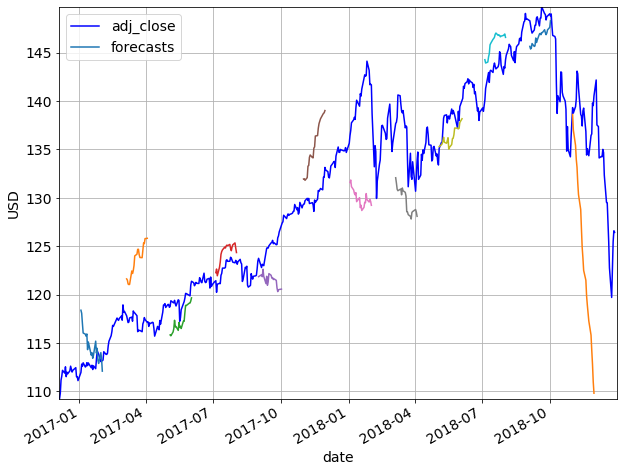

In [186]:
# Plot the predictions, and zoom in
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
firstDay = df['date'][min(i_list)]-timedelta(days=daysBackward)
lastDay = df['date'][max(i_list)]+timedelta(days=daysForward)
ax.set_ylim([min(min(min(preds_dict.values())), 
                 df[(df['date']>=firstDay) & (df['date']<=lastDay)]['adj_close'].min()
                ), 
             max(max(max(preds_dict.values())), 
                 df[(df['date']>=firstDay) & (df['date']<=lastDay)]['adj_close'].max()
                )
            ])
ax.set_xlim([firstDay, lastDay]) 
ax.legend(['adj_close', 'forecasts'])

# Save figure:
fig = ax.get_figure()
fig.savefig("./out/forecasts_" + str(train_size) + "_" + str(val_size) + ".png", bbox_inches='tight')

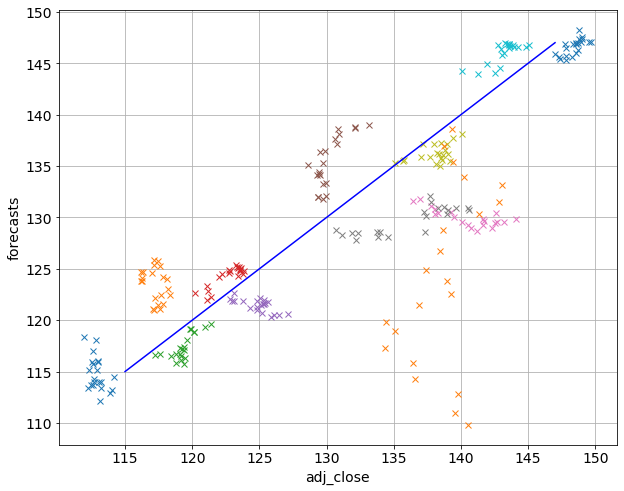

In [187]:
# Plot scatter plot of actual values vs. predictions
for key in preds_dict:
    plt.plot(df['adj_close'][key:key+H], preds_dict[key], 'x')
    
plt.plot(range(int(min(min(preds_dict.values()))), int(max(max(preds_dict.values()))), 1), 
         range(int(min(min(preds_dict.values()))), int(max(max(preds_dict.values()))), 1), 'b-')
    
plt.xlabel('adj_close')
plt.ylabel('forecasts')
plt.grid()

# Save figure:
plt.savefig("./out/forecasts_vs_actuals_" + str(train_size) + "_" + str(val_size) + ".png", bbox_inches='tight')

# Findings

In [188]:
rmse_no_tune = pickle.load(open( "./out/rmse_no_tune_v5a_" + str(train_size) + "_" + str(val_size) + ".pickle", "rb"))
rmse_no_tune

10.158112922716029

In [189]:
rmse_w_tune = pickle.load(open( "./out/rmse_w_tune_v5a_" + str(train_size) + "_" + str(val_size) + ".pickle", "rb"))
rmse_w_tune

5.276841091380223

In [190]:
results_final = pickle.load(open( "./out/results_final_v5a_" + str(train_size) + "_" + str(val_size) + ".pickle", "rb"))
results_final

,rmse,mape,mae,alpha_opt,beta_opt,gamma_opt,day
0,2.703389,1.906409,2.147813,0.029,0.280,0.57,2017-01-03
1,6.486329,5.304453,6.212351,0.007,0.029,0.50,2017-03-06
2,2.094938,1.612780,1.924748,0.066,0.005,0.78,2017-05-04
3,1.694649,1.317929,1.615172,0.010,0.012,0.32,2017-07-05
4,3.798687,2.733136,3.427066,0.011,0.019,0.24,2017-09-01
5,5.467660,3.971165,5.175733,0.010,0.185,0.20,2017-11-01
6,10.841264,7.421732,10.464188,0.004,0.034,0.54,2018-01-03
7,6.761241,4.663074,6.390550,0.017,0.039,0.89,2018-03-06
8,2.133157,1.330727,1.844073,0.040,0.012,0.40,2018-05-04
9,2.957759,2.001277,2.863436,0.010,0.140,0.47,2018-07-05


In [191]:
train_size

756

In [192]:
val_size

63

In [194]:
# Collect the results from various experiments
# # alpha - smoothing coeff
# alphaMax = 0.999
# alphaMin = 0.01
# alphaStep = 0.01

# # beta - trend coeff
# betaMax = 0.999
# betaMin = 0.01
# betaStep = 0.01

# # gamma - seasonality coeff
# gammaMax = 0.99
# gammaMin = 0.1
# gammaStep = 0.1

# # finetuning parameters
# finetune_width = 0.01       # for alpha and beta
# finetune_step = 0.001       # for alpha and beta
# finetune_width_gamma = 0.1  # for gamma only
# finetune_step_gamma = 0.01  # for gamma only

# L = 252                        # seasonality period

results_dict = pd.DataFrame({'train_size': [756, 756, 756],
                             'val_size': [21, 63, 252],
                             'before_tune_rmse': [11.076154, 10.158113, 6.793266],
                             'after_tune_rmse': [4.471570, 5.276841, 4.369605]})
results_dict

,train_size,val_size,before_tune_rmse,after_tune_rmse
0,756,21,11.076154,4.471570
1,756,63,10.158113,5.276841
2,756,252,6.793266,4.369605
